<a href="https://colab.research.google.com/github/phsimon/LSTM_Last.fm/blob/main/RS/RS_assessement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieve data from repository

In [27]:
import pandas as pd
my_path="/content/drive/MyDrive/ColabNotebooks/publication/publi_github/"

In [28]:
# install lenskit
%pip install lenskit

In [29]:
def convert_df_2_dict(my_dataframe):
  '''
  '''
  my_dico=my_dataframe.to_dict('split')
  return dict(my_dico['data'])

In [30]:
import json

with open(my_path+'target_ten_parameter.json') as file:
  parameter_data = json.load(file)
one_hot_space_size=parameter_data['one_hot_size']  
data_train_out_valid= pd.read_csv(my_path+"target_ten_data_train_out_valid",index_col=0)
data_train_out_valid_topn=pd.read_csv(my_path+"target_ten_data_train_out_valid_topn",index_col=0)
data_train_out_valid_topn_without_doublon=pd.read_csv(my_path+"target_ten_data_train_out_valid_topn_without_doublon",index_col=0)
data_valid=pd.read_csv(my_path+"target_ten_data_valid",index_col=0)
data_valid_topn=pd.read_csv(my_path+"target_ten_data_valid_topn",index_col=0)
data_valid_topn_without_doublon=pd.read_csv(my_path+"target_ten_data_valid_topn_without_doublon",index_col=0)
data_train=pd.read_csv(my_path+"target_ten_data_train",index_col=0)
data_test=pd.read_csv(my_path+"target_ten_data_test",index_col=0)
data_test_topn=pd.read_csv(my_path+"target_ten_data_test_topn",index_col=0)
data_test_topn_without_doublon=pd.read_csv(my_path+"target_ten_data_test_topn_without_doublon",index_col=0)
# reconstituer les dictionnaire
song_2_int=pd.read_csv(my_path+"target_ten_song_2_int")
song_2_int=convert_df_2_dict(song_2_int)
int_2_song=pd.read_csv(my_path+"target_ten_int_2_song")
int_2_song=convert_df_2_dict(int_2_song)
song_topn_2_int=pd.read_csv(my_path+"target_ten_song_topn_2_int")
song_topn_2_int=convert_df_2_dict(song_topn_2_int)
int_2_song_topn=pd.read_csv(my_path+"target_ten_int_2_song_topn")
int_2_song_topn=convert_df_2_dict(int_2_song_topn)

In [31]:
data_train_out_valid_topn_without_doublon.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
26,603,2,265,6,998,13,74,99,958,1565,165,148,312,552,826,183,16446,689,2148,80
53,30401,511,6,888,4936,265,19227,25702,1047,245,5389,2482,1507,1329,1205,1212,1194,1503,6217,3050
169,1348,3350,826,808,814,4504,2704,1944,1480,1465,242,6333,1002,707,10122,3373,1937,1454,1862,51604
309,988,5208,707,5020,1565,1440,953,4777,970,22522,967,1010,1027,5158,1476,799,22569,688,3621,1941
569,3398,6587,30455,24620,2345,1347,2060,2969,4057,2724,2982,3316,28,19963,2385,3710,13878,16267,30657,14737


# Constantes

In [32]:
num_prediction=10

# Format data

**Train / Test.**<br>
The train set will consist of the data_train_out_valid_xxx set and the data_test_xxx set in part. In fact, for data_test_xxx, only the first ten will be retained for each sequence.<br>
**Why?**<br> the objective is to be able to take measurements with classic recommendation algorithms (RS) and to compare with those obtained with LSTMs. To do this, the RS should ideally operate on the same data. However, for LSTMs, the learning is done on the “train_out_valid” set and there is a “valid” set used to control the learning. It is considered that the latter (“valid”) is not used for learning and therefore it is excluded from the dataset of classical algorithms (at least those which do not require a set of validation). The test set that is used to generate evaluation metrics is "data_test_xxx". For LSTMs, we proceed as follows: each history comprising exactly 20 items (note that we filter beforehand to retain only such user having a history of length 20) we take the 10 oldest as input (index from 0 to 9) and we seeks to predict the other 10 (index from 10 to 19). For the classic algos which take a "user" as input, this user must be known by the system to have a recommendation (there is no fit_partial service as standard for new users), then we integrate into the data_train the oldest 10 item history (the one which is used as an input for the LSTM). In practice, either u_test an unser of the test set and item_u_test_i the item i of its history, we integrate all the pairs (user, item_u_test_i) for i from 0 to 9.
For the evaluation, we will ask for 10 recommendations for the users of the test set, and we will compare to the 10 items from india 10 to 19 (as for the LSTM).
   


In [33]:
len(data_test_topn_without_doublon)

126559

In [34]:
# data_train_out_valid_topn_without_doublon
tab_logs=[]
i=1
for j in range(len(data_train_out_valid_topn_without_doublon)):
  #print(data_train_out_valid_topn_without_doublon.iloc[j])
  count=0
  for item in data_train_out_valid_topn_without_doublon.iloc[j]:
    #tab_logs.append([i,item,((count%10)//5)*4 +1])
    tab_logs.append([i,item,(count%10)+1])
    count+=1
  i+=1



In [35]:
# doit valoir len(data_train_xxx*20)
len(tab_logs)

113520

In [36]:
# sampling boolean
SAMPLING=False

In [37]:
# test set
import numpy as np
THRESHOLD=19
test_set=[user for user in data_test_topn_without_doublon.index if np.count_nonzero(data_test_topn_without_doublon.loc[user])> THRESHOLD]
#test_set=[user for user in test_set if np.count_nonzero(data_test_topn_without_doublon.loc[user])> THRESHOLD]

In [38]:
len(test_set)

1504

In [39]:
train_set_list=[x for y in data_train_out_valid_topn_without_doublon.index for x in data_train_out_valid_topn_without_doublon.loc[y]]
test_set_list=[x for y in test_set for x in data_test_topn_without_doublon.loc[y][:10]]


In [40]:
len(set(test_set_list))

4671

In [41]:

# sampling ensemble de test
import numpy as np
THRESHOLD=19
sample_test_0=[user for user in data_test_topn_without_doublon.index if (user%10==0)]
sample_test_0=[user for user in sample_test_0 if np.count_nonzero(data_test_topn_without_doublon.loc[user])> THRESHOLD]

In [42]:
if SAMPLING: 
  # adding part of test set to train set
  i=tab_logs[-1][0]+1  #on incrémente de 1 le dernier user de tab_logs 
  sample_test_0_reindexed={}
  for user in sample_test_0:
    count=0
    for item in data_test_topn_without_doublon.loc[user][:10]:
      #tab_logs.append([i,item,((count%10)//5)*4 +1])    
      tab_logs.append([i,item,(count%10)+1])
      count+=1
    sample_test_0_reindexed[i]=list(data_test_topn_without_doublon.loc[user][10:])
    i+=1
  sample_test_0_user_list=list(sample_test_0_reindexed.keys())

In [43]:
if not SAMPLING:
  # without sampling
  count_user=0
  i=tab_logs[-1][0]+1  #on incrémente de 1 le dernier user de tab_logs 
  test_reindexed={}
  for user in test_set:
    count=0
    count_user+=1
    for item in data_test_topn_without_doublon.loc[user][:10]:
      #tab_logs.append([i,item,((count%10)//5)*4 +1])    
      tab_logs.append([i,item,(count%10)+1])
      count+=1
    test_reindexed[i]=list(data_test_topn_without_doublon.loc[user][10:])
    i+=1

  test_user_list=list(test_reindexed.keys())

In [44]:
len(tab_logs)

128560

In [45]:
tab_logs=np.array(tab_logs)
tab_logs.shape

(128560, 3)

In [46]:
liste_item=np.unique(tab_logs[:,1])
len(liste_item)

11025

In [47]:
# doit valoir len(data_train_xxx*20)+ len(data_test_xxx*10)
print(len(tab_logs))
print(len(data_train_out_valid_topn_without_doublon)*20+(len(test_reindexed)*10))

128560
128560


In [48]:
ratings=pd.DataFrame(tab_logs,columns=['user','item','rating'])

In [49]:
ratings.tail()

,user,item,rating
128555,7180,1999,6
128556,7180,988,7
128557,7180,723,8
128558,7180,1470,9
128559,7180,2558,10


In [50]:
len(np.unique(ratings['user']))

7180

In [51]:
average_measure={}
average_measure['PREC'],average_measure['MAP'], average_measure['MRR'],average_measure['NDCG'] =[],[],[],[]

# Random recsys

In [ ]:
dico_reco={}
for user in test_reindexed:
  reco=[]
  # selection du dernier item vu
  reco=list(np.random.choice(liste_item, size=num_prediction*4, replace=True))
  reco=[x for x in reco if x not in test_reindexed[user]]
  dico_reco[user]=reco[:num_prediction]

# Next One (Markov Chain - or conditionnal proba)

Two approaches:
- look for the item just after the last seen (get_next_item_list)
- search for all items seen after the last seen (get_next_items_list)

it seems that the two methods lead to identical results for precision.

Getting recommendation for users from the test dataset

In [52]:
from collections import Counter

def get_occurrence_item(item, dataset):
  '''
    :param item : int item identifiant
    :dataset : dataframe each line content the list of item a user has viewed
    :return dataset_filtered: list with only the line which content the item
  '''
  tab_occu_item=[]
  for j in range(len(dataset)):
    ma_liste=list(dataset.iloc[j])
    if item in ma_liste and ma_liste[-1]!=item:
      tab_occu_item.append(ma_liste)
  return tab_occu_item    


def get_next_item_list(item, dataset, size_list):
  '''
    :param item : int item identifiant
    :dataset : dataframe each line content the list of item a user has viewed
    :size_list : nombre d'items souhaités
    :return list_item: list of user identifiant sortered by popularity
  '''
  #obtention des enregistrements contenant "item" (pas en dernière position)
  tab_occ=[]
  tab_occ_item=get_occurrence_item(item,dataset)
  #enregistrement des co-occurrences
  for i in range(len(tab_occ_item)):
    history=tab_occ_item[i]
    # identification de la position de "item"
    index_item=history.index(item)
    #enregistrement de l'item suivant, toujours possible car item n'est pas en dernière position
    tab_occ.append(history[index_item+1])
  result=Counter(tab_occ)
  result=sorted(result.items(),key=lambda t: t[1],reverse=True)
  result1=[x[0] for x in result[:size_list]]
  return result1,result  

def get_back_item_list(item, dataset, size_list):
  '''
    :param item : int item identifiant
    :dataset : dataframe each line content the list of item a user has viewed
    :size_list : nombre d'items souhaités
    :return list_item: list of user identifiant sortered by popularity
  '''
  #obtention des enregistrements contenant "item" (pas en dernière position)
  tab_occ=[]
  tab_occ_item=get_occurrence_item(item,dataset)
  #enregistrement des co-occurrences
  for i in range(len(tab_occ_item)):
    history=tab_occ_item[i]
    # identification de la position de "item"
    index_item=history.index(item)
    #enregistrement de l'item précédent, toujours possible car item n'est pas en dernière première position
    tab_occ.append(history[index_item-1])
  result=Counter(tab_occ)
  result=sorted(result.items(),key=lambda t: t[1],reverse=True)
  result1=[x[0] for x in result[:size_list]]
  return result1,result 


def get_next_items_list(item, dataset, size_list):
  '''
    :param item : int item identifiant
    :dataset : dataframe each line content the list of item a user has viewed
    :size_list : nombre d'items souhaités
    :return list_item: list of user identifiant sortered by popularity
  '''
  #obtention des enregistrements contenant "item" (pas en dernière position)
  tab_occ=[]
  tab_occ_item=get_occurrence_item(item,dataset)
  #enregistrement des co-occurrences
  for i in range(len(tab_occ_item)):
    history=tab_occ_item[i]
    # identification de la position de "item"
    index_item=history.index(item)
    #enregistrement de l'item suivant, toujours possible car item n'est pas en dernière position
    for content in history[index_item+1:]:
      tab_occ.append(content)
  result=Counter(tab_occ)
  result=sorted(result.items(),key=lambda t: t[1],reverse=True)
  result1=[x[0] for x in result[:size_list]]
  return result1, result


def get_back_items_list(item, dataset, size_list):
  '''
    :param item : int item identifiant
    :dataset : dataframe each line content the list of item a user has viewed
    :size_list : nombre d'items souhaités
    :return list_item: list of user identifiant sortered by popularity
  '''
  #obtention des enregistrements contenant "item" (pas en dernière position)
  tab_occ=[]
  tab_occ_item=get_occurrence_item(item,dataset)
  #enregistrement des co-occurrences
  for i in range(len(tab_occ_item)):
    history=tab_occ_item[i]
    # identification de la position de "item"
    index_item=history.index(item)
    #enregistrement de l'item précédent, toujours possible car item n'est pas en première position
    for content in history[:index_item]:
      tab_occ.append(content)
  result=Counter(tab_occ)
  result=sorted(result.items(),key=lambda t: t[1],reverse=True)
  result1=[x[0] for x in result[:size_list]]
  return result1,result



In [ ]:
# test unitaire
ma_tab=get_occurrence_item(2,data_train_out_valid_topn_without_doublon)
result=get_back_items_list(2,data_train_out_valid_topn_without_doublon,5)[0]

In [ ]:
# test unitaire
print(result)

[148, 13, 603, 99, 77]


In [ ]:
dico_reco={}
for user in test_reindexed:
  # selection du dernier item vu
  last_item=test_reindexed[user][-1]
  candidats=get_next_item_list(last_item,data_train_out_valid_topn_without_doublon,num_prediction+ THRESHOLD + 1)
  result=[x for x in candidats if x not in test_reindexed[user]]
  dico_reco[user]=get_next_item_list(last_item,data_train_out_valid_topn_without_doublon,num_prediction)[0]

# ALS

In [ ]:
from lenskit.algorithms.als import ImplicitMF
ALS_Implicit=ImplicitMF(features=100,iterations=30,reg=0.1,weight=1,method='cg')

In [ ]:
ratings[['user','item']]

,user,item
0,1,603
1,1,2
2,1,265
3,1,6
4,1,998
...,...,...
128555,7180,1999
128556,7180,988
128557,7180,723
128558,7180,1470


In [ ]:
ALS_Implicit.fit(ratings[['user','item']])

In [ ]:
ALS_Implicit.fit(ratings)

In [ ]:
prediction=ALS_Implicit.predict_for_user(test_user_list[0],np.unique(ratings["item"]))

In [ ]:
prediction.head()

1    0.198171
2    0.835042
4    0.060346
5    0.013920
6    0.041243
dtype: float64

(array([2.000e+01, 1.269e+03, 9.575e+03, 1.130e+02, 2.900e+01, 6.000e+00,
        3.000e+00, 4.000e+00, 2.000e+00, 4.000e+00]),
 array([-0.24980462, -0.13239564, -0.01498667,  0.1024223 ,  0.21983128,
         0.33724025,  0.45464922,  0.5720582 ,  0.68946717,  0.80687614,
         0.92428512]),
 <a list of 10 Patch objects>)

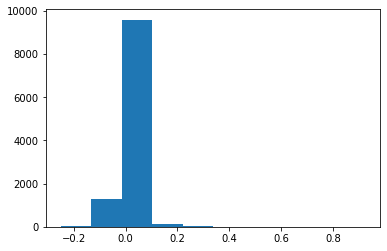

In [ ]:
import matplotlib.pyplot as plt
plt.hist(prediction)

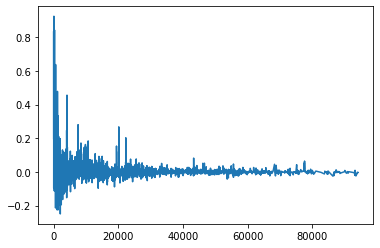

In [ ]:
plt.plot(prediction)

In [ ]:
prediction_test=prediction.sort_values(ascending=False)[:10]
print(prediction_test)

74     0.924285
39     0.905347
265    0.842553
2      0.835042
76     0.774081
166    0.728880
244    0.677231
92     0.649961
601    0.637282
99     0.635415
dtype: float64


In [ ]:
dico_reco={}
for user in test_reindexed:
  history_user=ratings[ratings['user']==user]
  #print(history_user)
  # obtention des predictions
  prediction_user=ALS_Implicit.predict_for_user(user,np.unique(ratings["item"]))
  
  prediction_user=prediction_user.sort_values(ascending=False)
  #print(prediction_user)
  
  #candidats=[x for x in prediction_user.index[:num_prediction+THRESHOLD+1] if x not in list(ratings[ratings["user"]==x]['item'])] 
  candidats=[x for x in prediction_user.index[:num_prediction+THRESHOLD+1] ] 
  reco=[x for x in candidats if x not in list(ratings[ratings["user"]==user]['item'])]
  dico_reco[user]=reco[:num_prediction]



# Most popular

In [ ]:
from lenskit.algorithms.basic import Popular

In [ ]:
popular = Popular()
popular.fit(ratings)

In [ ]:
popular.recommend(user=5677,n=10)

,item,score
0,28,912.0
1,13,683.0
2,349,582.0
3,80,517.0
4,840,510.0
5,1348,474.0
6,1438,472.0
7,1289,445.0
8,826,437.0
9,77,428.0


In [ ]:
dico_reco={}
for user in test_reindexed:
  history_user=ratings[ratings['user']==user]
  #print(history_user)
  # obtention des predictions
  prediction_user=popular.recommend(user=user,n=num_prediction)
  dico_reco[user]=list(prediction_user['item'])

In [ ]:
prediction_user

,item,score
0,13,683.0
1,349,582.0
2,80,517.0
3,840,510.0
4,1348,474.0
5,1438,472.0
6,1289,445.0
7,826,437.0
8,77,428.0
9,603,423.0


# KNN

# User KNN

In [ ]:
from lenskit.algorithms.user_knn import UserUser
knn_user=UserUser(50,3)

In [ ]:
knn_user.fit(ratings)

In [ ]:
knn_test=knn_user.predict_for_user(test_user_list[0],np.unique(ratings["item"]))

In [ ]:
knn_test.sort_values(ascending=False)[:30]

item
1314     9.800191
9820     9.773585
5404     9.618644
4128     9.570370
6508     9.500000
2000     9.381818
724      9.224138
1796     9.173913
408      9.082803
8575     9.074074
3599     9.063830
2677     9.010091
691      8.979592
2        8.978223
6875     8.892857
4424     8.846154
1131     8.845361
1411     8.819549
6533     8.797468
244      8.728472
153      8.704918
1905     8.671642
502      8.666667
54008    8.666667
14185    8.655293
205      8.608392
3070     8.583333
3271     8.571429
1634     8.565014
3138     8.529412
Name: prediction, dtype: float64

In [ ]:
dico_reco={}
for user in test_reindexed:
  history_user=ratings[ratings['user']==user]
  #print(history_user)
  # obtention des predictions
  prediction_user=knn_user.predict_for_user(user,np.unique(ratings["item"]))
  
  prediction_user=prediction_user.sort_values(ascending=False)
  #print(prediction_user)
  
  #candidats=[x for x in prediction_user.index[:num_prediction+THRESHOLD+1] if x not in list(ratings[ratings["user"]==x]['item'])] 
  candidats=[x for x in prediction_user.index[:num_prediction+THRESHOLD+1] ] 
  reco=[x for x in candidats if x not in list(ratings[ratings["user"]==user]['item'])]
  dico_reco[user]=reco[:num_prediction]



# Item KNN

In [ ]:
from lenskit.algorithms.item_knn import ItemItem
knn_item=ItemItem(100,5)

In [ ]:
knn_item.fit(ratings)

In [ ]:
knn_test_item=knn_item.predict_for_user(test_user_list[0],np.unique(ratings["item"]))

In [ ]:
pd_tab_logs=pd.DataFrame(tab_logs,columns=['user','item','rating'])

In [ ]:
knn_test_item.sort_values(ascending=False)[:20]

item
1171    8.651447
1083    8.400740
1341    8.380016
40      8.344744
244     8.248846
89      8.245336
60      8.212507
955     7.924527
1550    7.856857
4070    7.720704
331     7.702140
44      7.669370
7540    7.647260
1474    7.644131
102     7.615618
2330    7.607264
84      7.489322
346     7.447219
34      7.396397
977     7.354375
dtype: float64

(array([ 5., 10., 20., 18., 27., 28., 22., 14., 13.,  7.]),
 array([1.74228074, 2.43319734, 3.12411395, 3.81503056, 4.50594717,
        5.19686378, 5.88778039, 6.57869699, 7.2696136 , 7.96053021,
        8.65144682]),
 <a list of 10 Patch objects>)

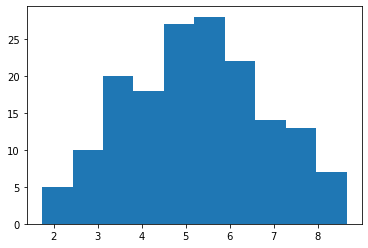

In [ ]:
plt.hist(knn_test_item)

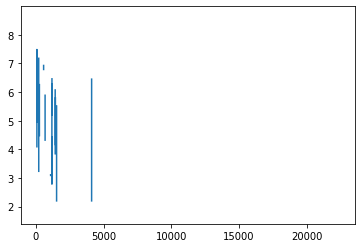

In [ ]:
plt.plot(knn_test_item)

In [ ]:
dico_reco={}
for user in test_reindexed:
  history_user=ratings[ratings['user']==user]
  #print(history_user)
  # obtention des predictions
  prediction_user=knn_item.predict_for_user(user,np.unique(ratings["item"]))
  
  prediction_user=prediction_user.sort_values(ascending=False)
  #print(prediction_user)
  
  #candidats=[x for x in prediction_user.index[:num_prediction+THRESHOLD+1] if x not in list(ratings[ratings["user"]==x]['item'])] 
  candidats=[x for x in prediction_user.index[:num_prediction+THRESHOLD+1] ] 
  reco=[x for x in candidats if x not in list(ratings[ratings["user"]==user]['item'])]
  dico_reco[user]=reco[:10]


# Calcul des KPIs, precision, NDCG

In [ ]:
# calcul max_DCG
import math
def log2(x):
 return(math.log(x,2))
max_DCG=0.
for i in range(1,num_prediction+1):
    max_DCG+=(2**(num_prediction+1-i)-1)/log2(i+1)
print("max_DCG",max_DCG)    

max_DCG 1571.4155855572703


In [ ]:
if SAMPLING:
  test_set=sample_test_0_reindexed
else:
  test_set=test_reindexed  

In [ ]:
# calcul de la précision, sur ensemble de test
tab_AP=[]
precision_at_k=0.
MRR=0.
DCG=0.
count=0  
count_MRR=0 
count_DCG=0
average_DCG=0
new_max_sequence_label=10
label_set=set({})
reco_set=set({})
for user in test_set:
  # initialisation des variables
  tab_P=[]
  label=test_set[user][-num_prediction:]  # on prend les max_sequence_label derniers...ceux d'avant ont été entré pour demander une prédiction
  label_set.update(set(label))
  reco_set.update(set(dico_reco[user]))
  # on peut travailler avec les listes car pas de doublon
  retrieved_song=[x for x in dico_reco[user] if x in label]
  #precision@(num_prediction) 
  for song_index in retrieved_song:
    precision_at_k+=min(label.count(song_index),dico_reco[user].count(song_index))
  count+=1
  
  #AP@k
  # d'après https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
  P=0
  for rank in range(1,min(num_prediction,len(label))+1):
      # calcul P@rank
      if len(dico_reco[user])>= rank:
        if dico_reco[user][rank-1] in label:
            P+=1.0
            AP_inter=P/rank
            tab_P.append(AP_inter)
        else:
            continue
      else:
        break      

  if len(retrieved_song)!=0:
      AP=sum(tab_P)/len(retrieved_song)
  else:
      AP=0
  tab_AP.append(AP)  
  
  #MRR
  # see https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
  for song in dico_reco[user]:
    if song in label:
      MRR+=1.0/(dico_reco[user].index(song)+1)
      count_MRR+=1
      break
    else:
      continue  
  
  #NDCG  
  DCG=0
  for song in dico_reco[user]:
    if song in label:
      DCG+=(2**(num_prediction-label.index(song))-1)/log2(dico_reco[user].index(song)+2)
    else:
      continue
  DCG/=max_DCG
  average_DCG+=DCG    
  
print(count)
print("precision",precision_at_k)
 
precision_at_k=float(precision_at_k)/float(count*num_prediction)
MRR=float(MRR)/float(count)
MAP=sum(tab_AP)/len(tab_AP)
average_DCG=float(average_DCG)/float(count)

print("precision at {} sur ensemble de train complet égale à {}".format(num_prediction,precision_at_k))
print("nommbre de user sur lequel la precision peut être calculé : {}".format(count))
print("MRR sur ensemble de train complet égale à {}".format(MRR))
print("nombre de user sur lesquel MRR peut être calculé : {}".format(count_MRR))
print("MAP sur ensemble de train complet égale à {}".format(MAP))
print("nommbre de user sur lequel MAP peut être calculé : {}".format(len(tab_AP)))
print("NDCG sur ensemble de train complet égale à {}".format(average_DCG))
print("nommbre d'item pour lequel DCG peut être calculé : {}".format(count))
#print("couverture_ coverage: {}".format(len(reco_set)/len(label_set)))
print("couverture_ coverage: {}".format(len(reco_set)/len(liste_item)))


print("nombre de user pris en compte : {}".format(count))

1504
precision 382.0
precision at 10 sur ensemble de train complet égale à 0.025398936170212764
nommbre de user sur lequel la precision peut être calculé : 1504
MRR sur ensemble de train complet égale à 0.0866638698919284
nombre de user sur lesquel MRR peut être calculé : 307
MAP sur ensemble de train complet égale à 0.08466061402397837
nommbre de user sur lequel MAP peut être calculé : 1504
NDCG sur ensemble de train complet égale à 0.01893867678536191
nommbre d'item pour lequel DCG peut être calculé : 1504
couverture_ coverage: 0.2620408163265306
nombre de user pris en compte : 1504


In [ ]:

average_measure['PREC'].append(precision_at_k)
average_measure['MAP'].append(MAP)
average_measure['MRR'].append(MRR)
average_measure['NDCG'].append(average_DCG)

In [ ]:
average_measure

{'MAP': [0.13252679802713027,
  0.09660722640858943,
  0.0,
  0.2185706416382549,
  0.13252679802713027,
  0.09660722640858943,
  0.08466061402397837],
 'MRR': [0.1373311381290102,
  0.10081871622762578,
  0.0,
  0.24301808932792945,
  0.1373311381290102,
  0.10081871622762578,
  0.0866638698919284],
 'NDCG': [0.02900684048388581,
  0.023118883093342032,
  0.0,
  0.07012368517876799,
  0.02900684048388581,
  0.023118883093342032,
  0.01893867678536191],
 'PREC': [0.037101063829787236,
  0.03357712765957447,
  0.0,
  0.0988031914893617,
  0.037101063829787236,
  0.03357712765957447,
  0.025398936170212764]}

#init var

In [68]:
tab_result=[]

# Commutativity stats

In [125]:
nb_item=len(np.unique(ratings['item']))

In [126]:
# pairs numbers
nb_item*(nb_item-1)/2

60769800.0

In [127]:
# should take 383 pairs and examine if they commute (échantillon pour avoir une marge de 5% d'erreur)
# choose within the logs to pickup more frequently popular item

In [128]:
sampling_size=400
count=0
tab_paire=[]
seq_sampled=data_train_out_valid_topn_without_doublon.sample(sampling_size)
#for index in range(seq_sampled.shape[0]):
for index in range(data_train_out_valid_topn_without_doublon.shape[0]):
  # select pair of item from a seq
  count_iter=0
  while count_iter < 2:
    paire=np.random.choice(list(data_train_out_valid_topn_without_doublon.iloc[index]),size=2)
    #paire=np.random.choice(list(seq_sampled.iloc[index]),size=2)
    count_iter+=1
    if len(np.unique(paire))==2:   # check the item are not the same
      if set(paire) not in tab_paire:  # check the pair is not already in our set
        tab_paire.append(set(paire))
        count+=1
      else:
        continue  
    else:
      continue    

In [129]:
# for each pair look how many in one order and how many in the opposite order
dico_commut={}
for paire in tab_paire:
  liste_seq=[]
  paire_1=tuple(paire)
  dico_commut[paire_1]={}
  dico_commut[paire_1]['left']=0
  dico_commut[paire_1]['right']=0
  # number of occurrence of paire_1
  liste_seq=get_occurrence_item(paire_1[0], data_train_out_valid_topn_without_doublon)
  for seq in liste_seq:
    if paire_1[1] in seq:
      index_pivot=seq.index(paire_1[0])
      if seq.index(paire_1[1])>index_pivot:
        dico_commut[paire_1]['left']+=1
      else:
        dico_commut[paire_1]['right']+=1



In [ ]:
dico_commut.values()

In [131]:
len(dico_commut)

10541

In [132]:
dico_commut_relative={}
for paire in dico_commut:
  dico_commut_relative[paire]=dico_commut[paire]['right']-dico_commut[paire]['left'] 

In [133]:
dico_commut_relative_filtered={}
count_sup_1,count_single_pair=0,0
for paire in dico_commut:
  if dico_commut[paire]['right']+dico_commut[paire]['left'] > 1: # pair exist more than one time
      count_sup_1+=1
      dico_commut_relative_filtered[paire]=dico_commut[paire]['right']-dico_commut[paire]['left'] 
  else:
      count_single_pair+=1    

In [134]:
print("singleton",count_single_pair,"non singleton",count_sup_1)
#dico_commut_relative_filtered

singleton 4846 non singleton 5695


In [135]:
distrib=list(dico_commut_relative.values())
print(np.average(distrib))
print(np.std(distrib))
f=lambda x: np.abs(x)
print(np.sum(f(distrib)))

-0.1945735698700313
2.3842510818985976
16753


(array([3.000e+00, 2.000e+00, 6.000e+00, 1.100e+01, 1.700e+01, 1.400e+01,
        2.200e+01, 3.100e+01, 4.600e+01, 8.300e+01, 1.250e+02, 2.000e+02,
        3.960e+02, 8.230e+02, 3.069e+03, 1.490e+03, 2.790e+03, 7.260e+02,
        3.160e+02, 1.310e+02, 8.400e+01, 4.700e+01, 3.200e+01, 1.900e+01,
        1.300e+01, 1.100e+01, 2.000e+00, 5.000e+00, 7.000e+00]),
 array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
         -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14]),
 <a list of 29 Patch objects>)

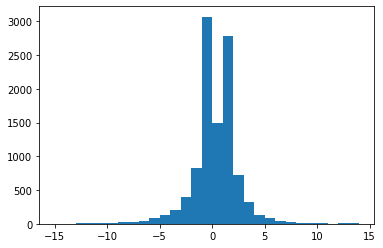

In [136]:
import matplotlib.pyplot as plt
plt.hist(dico_commut_relative.values(),bins=range(-15,+15,1))

(array([   3.,    2.,    6.,   11.,   17.,   14.,   22.,   31.,   46.,
          83.,  125.,  200.,  396.,  823.,  650., 1267.,  586.,  726.,
         316.,  131.,   84.,   47.,   32.,   19.,   13.,   11.,    2.,
           5.,    7.]),
 array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
         -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14]),
 <a list of 29 Patch objects>)

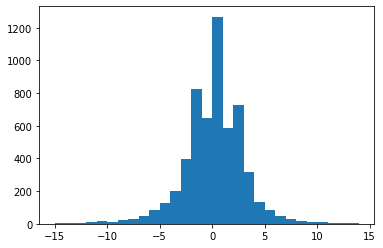

In [137]:
plt.hist(dico_commut_relative_filtered.values(),bins=range(-15,+15,1))

In [138]:
distrib=list(dico_commut_relative_filtered.values())
print(np.average(distrib))
print(np.std(distrib))
f=lambda x: np.abs(x)
print(np.sum(f(distrib)))

-0.32238805970149254
3.110662947399558
12130


In [139]:
tab_result.append([np.average(distrib),np.std(distrib)])

In [140]:
tab_result

[[-0.2523364485981308, 2.957940234159307],
 [-0.023148148148148147, 3.14678279215695],
 [-0.5343137254901961, 3.3757786348889045],
 [-0.3500717360114778, 3.157545203867812],
 [-0.32238805970149254, 3.110662947399558]]